In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 서울시 구별 CCTV 현황 분석

### 1. 데이터 준비

+ https://opengov.seoul.go.kr
    - 구글에서 "서울시 cctv 현황" 검색을 통해 데이터 수집
    - cctv.csv
    
    
+ https://data.seoul.go.kr
    - 구글에서 "서울시 인구" 검색을 통해 데이터 수집
    - Report.xls

In [2]:
##### CCTV 자료

cctv_seoul = pd.read_csv("data/seoul/cctv.csv")
cctv_seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [6]:
##### 인구 수 자료

pop_seoul = pd.read_excel("data/seoul/Report.xls", usecols="B, D, G, J, N", header=2)
pop_seoul.head()

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10112070,9838892,273178,1382420
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752


### 2. EDA & Preprocessing

#### 2-1. 컬럼 이름 변경

In [12]:
# CCTV 자료에서 "기관명"이라는 컬럼을 "구별"로 변경
cctv_seoul.rename(columns={cctv_seoul.columns[0]:"구별"}, inplace=True)
cctv_seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [13]:
# 인구수 자료에서 컬럼명을 각각 구별, 인구수, 한국인, 외국인, 고령자로 변경
pop_seoul.rename(columns={pop_seoul.columns[0]:"구별",
                         pop_seoul.columns[1]:"인구수",
                         pop_seoul.columns[2]:"한국인",
                         pop_seoul.columns[3]:"외국인",
                         pop_seoul.columns[4]:"고령자"}, inplace=True)
pop_seoul.head()

,구별,인구수,한국인,외국인,고령자
0,합계,10112070,9838892,273178,1382420
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752


#### 2-2. CCTV 현황 탐색

+ 어느 구가 가장 CCTV가 많이 설치되었는가? 또는 가장 적게 설치된 곳은 어디인가?

In [15]:
##### 단순히 구별로 CCTV의 많고 적음을 탐색

cctv_seoul.sort_values(by="소계", ascending=False).head()
cctv_seoul.sort_values(by="소계", ascending=True).head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
9,도봉구,825,238,159,42,386
2,강북구,831,369,120,138,204
5,광진구,878,573,78,53,174
3,강서구,911,388,258,184,81
24,중랑구,916,509,121,177,109


In [18]:
##### CCTV의 설치 증가율에 따라 가장 높은 구와 가장 낮은 구를 탐색
##### CCTV의 설치 연도별 증가율을 구해서 "최근증가율" 파생변수 추가
##### ((2014 + 2015 + 2016) / 2013년도 이전) * 100

cctv_seoul["최근증가율"] = ((cctv_seoul["2014년"] + cctv_seoul["2015년"] + \
                        cctv_seoul["2016년"]) / cctv_seoul["2013년도 이전"]) * 100
cctv_seoul.head()

cctv_seoul.sort_values(by="최근증가율", ascending=False).head()
cctv_seoul.sort_values(by="최근증가율", ascending=True).head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
18,양천구,2482,1843,142,30,467,34.671731
13,서대문구,1254,844,50,68,292,48.578199
20,용산구,2096,1368,218,112,398,53.216374
5,광진구,878,573,78,53,174,53.228621
14,서초구,2297,1406,157,336,398,63.371266


#### 2-3. 인구 수 탐색

+ 어느 구가 가장 인구수가 많은가? 또는 적은가?

In [21]:
##### 필요없는 행 삭제(서울시 전체 합계 삭제) : del, drop()

pop_seoul.drop([0], inplace=True)
pop_seoul.head()

,구별,인구수,한국인,외국인,고령자
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752
5,광진구,371671,357149,14522,44470


In [29]:
##### 구별 데이터의 중복이나 결측치 등을 확인

print(pop_seoul["구별"].count())
print(len(pop_seoul["구별"].unique()))

pop_seoul[pop_seoul["구별"].isnull()]

25
26


,구별,인구수,한국인,외국인,고령자
26,NaN,0,0,0,0


In [30]:
##### 결측치 삭제

pop_seoul.drop([26], inplace=True)

In [32]:
pop_seoul["구별"].unique()
pop_seoul[pop_seoul["구별"].isnull()]

,구별,인구수,한국인,외국인,고령자


In [35]:
##### 단순히 인구수만 탐색(전체, 외국인, 고령자)

print(pop_seoul.sort_values(by="인구수", ascending=True).head())
print(pop_seoul.sort_values(by="인구수", ascending=False).head())

print("---------------------------------------------------------------------")

print(pop_seoul.sort_values(by="외국인", ascending=True).head())
print(pop_seoul.sort_values(by="외국인", ascending=False).head())

print("---------------------------------------------------------------------")

print(pop_seoul.sort_values(by="고령자", ascending=True).head())
print(pop_seoul.sort_values(by="고령자", ascending=False).head())

     구별     인구수     한국인    외국인    고령자
2    중구  135139  126082   9057  21655
1   종로구  164348  154549   9799  26429
3   용산구  245411  229909  15502  37238
18  금천구  253344  234238  19106  34640
4   성동구  314551  306532   8019  41752
     구별     인구수     한국인    외국인    고령자
24  송파구  671994  665282   6712  77978
16  강서구  608361  601696   6665  77381
23  강남구  557865  552976   4889  65859
11  노원구  555803  551902   3901  75081
21  관악구  522292  504445  17847  70807
---------------------------------------------------------------------
     구별     인구수     한국인   외국인    고령자
10  도봉구  345041  342861  2180  54293
9   강북구  327511  323862  3649  57002
15  양천구  473087  469221  3866  56070
11  노원구  555803  551902  3901  75081
25  강동구  438225  434027  4198  56983
      구별     인구수     한국인    외국인    고령자
19  영등포구  403988  369128  34860  54704
17   구로구  440396  408369  32027  59838
18   금천구  253344  234238  19106  34640
21   관악구  522292  504445  17847  70807
6   동대문구  364962  349308  15654  56284
------------------

In [36]:
##### 전체 인구 대비 외국인비율, 고령자비율 파생변수를 추가해서 순위 확인

pop_seoul["외국인비율"] = pop_seoul["외국인"] / pop_seoul["인구수"] * 100
pop_seoul["고령자비율"] = pop_seoul["고령자"] / pop_seoul["인구수"] * 100

In [37]:
print(pop_seoul.sort_values(by="외국인비율", ascending=True).head())
print(pop_seoul.sort_values(by="외국인비율", ascending=False).head())

print("---------------------------------------------------------------------")

print(pop_seoul.sort_values(by="고령자비율", ascending=True).head())
print(pop_seoul.sort_values(by="고령자비율", ascending=False).head())

     구별     인구수     한국인   외국인    고령자     외국인비율      고령자비율
10  도봉구  345041  342861  2180  54293  0.631809  15.735231
11  노원구  555803  551902  3901  75081  0.701867  13.508563
15  양천구  473087  469221  3866  56070  0.817186  11.851943
23  강남구  557865  552976  4889  65859  0.876377  11.805544
12  은평구  490253  485902  4351  75535  0.887501  15.407351
      구별     인구수     한국인    외국인    고령자     외국인비율      고령자비율
19  영등포구  403988  369128  34860  54704  8.628969  13.540996
18   금천구  253344  234238  19106  34640  7.541525  13.673109
17   구로구  440396  408369  32027  59838  7.272319  13.587317
2     중구  135139  126082   9057  21655  6.701988  16.024242
3    용산구  245411  229909  15502  37238  6.316750  15.173729
---------------------------------------------------------------------
     구별     인구수     한국인    외국인    고령자     외국인비율      고령자비율
24  송파구  671994  665282   6712  77978  0.998818  11.603973
23  강남구  557865  552976   4889  65859  0.876377  11.805544
15  양천구  473087  469221   3866  56070  0.8171

#### 2-4. 인구 대비 CCTV 설치 현황

In [38]:
##### CCTV 데이터와 인구수 데이터를 합치기

data_result = pd.merge(cctv_seoul, pop_seoul, on="구별")
data_result.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,1292,430,584,932,150.619195,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,379,99,155,377,166.490765,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,369,120,138,204,125.203252,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,388,258,184,81,134.793814,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,846,260,390,613,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [39]:
##### 필요없는 컬럼 제거 : 2013년도 이전, 2014년, 2015년, 2016년

del data_result["2013년도 이전"]
del data_result["2014년"]
del data_result["2015년"]
del data_result["2016년"]

In [40]:
data_result.head()

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [44]:
##### 구별 컬럼을 인덱스로 변경

data_result.set_index("구별", inplace=True)

KeyError: "None of ['구별'] are in the columns"

In [45]:
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [48]:
##### CCTV의 갯수(소계)와 인구 데이터 중 어느 변수와 관계가 있는지를 확인
##### np.corrcoef() : 상관계수 -1 ~ 1

print(np.corrcoef(data_result["고령자비율"], data_result["소계"]))
print(np.corrcoef(data_result["외국인비율"], data_result["소계"]))
print(np.corrcoef(data_result["인구수"], data_result["소계"]))

[[ 1.         -0.26783452]
 [-0.26783452  1.        ]]
[[ 1.         -0.04656978]
 [-0.04656978  1.        ]]
[[1.         0.23037183]
 [0.23037183 1.        ]]


In [49]:
##### 일단 중간 과정 저장
data_result.to_csv("data/seoul/cctv_result.csv", sep=",", encoding="utf-8")

In [3]:
##### 중간 과정 불러오기
data_result = pd.read_csv("data/seoul/cctv_result.csv", index_col="구별")
data_result

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976
광진구,878,53.228621,371671,357149,14522,44470,3.907219,11.964883
구로구,1884,64.973730,440396,408369,32027,59838,7.272319,13.587317
금천구,1348,100.000000,253344,234238,19106,34640,7.541525,13.673109
노원구,1566,188.929889,555803,551902,3901,75081,0.701867,13.508563


In [5]:
print(data_result.sort_values(by="소계", ascending=False).head())
print("-----------------------------------------------------------")
print(data_result.sort_values(by="인구수", ascending=False).head())

       소계       최근증가율     인구수     한국인    외국인    고령자     외국인비율      고령자비율
구별                                                                      
강남구  3238  150.619195  557865  552976   4889  65859  0.876377  11.805544
양천구  2482   34.671731  473087  469221   3866  56070  0.817186  11.851943
서초구  2297   63.371266  445164  440954   4210  54055  0.945719  12.142716
관악구  2109  149.290780  522292  504445  17847  70807  3.417054  13.556976
은평구  2108   85.237258  490253  485902   4351  75535  0.887501  15.407351
-----------------------------------------------------------
       소계       최근증가율     인구수     한국인    외국인    고령자     외국인비율      고령자비율
구별                                                                      
송파구  1081  104.347826  671994  665282   6712  77978  0.998818  11.603973
강서구   911  134.793814  608361  601696   6665  77381  1.095567  12.719586
강남구  3238  150.619195  557865  552976   4889  65859  0.876377  11.805544
노원구  1566  188.929889  555803  551902   3901  75081  0.701867  1

### 3. Visualization

#### 3-1. CCTV가 많이 설치된 구별 확인

<AxesSubplot:xlabel='구별'>

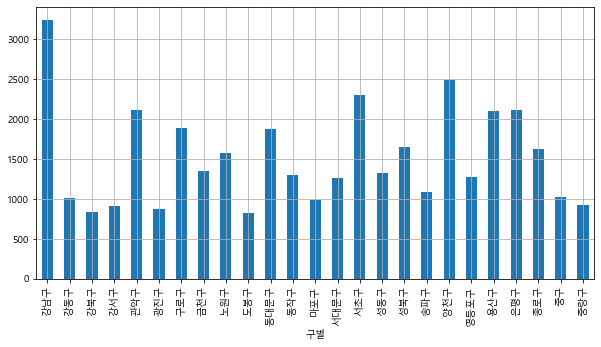

In [8]:
# data_result["소계"].plot(kind="bar")
# data_result["소계"].plot.bar()
data_result["소계"].plot(kind="bar", figsize=(10, 5), grid=True)

<AxesSubplot:ylabel='구별'>

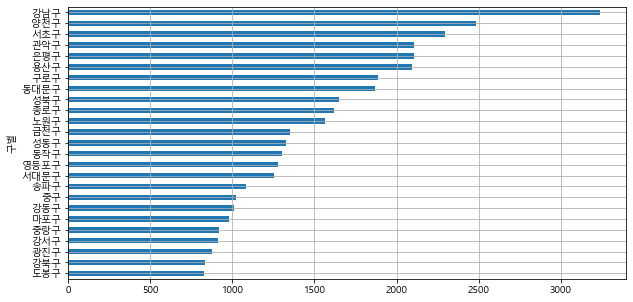

In [10]:
# data_result["소계"].plot(kind="barh", figsize=(10, 5), grid=True)
data_result["소계"].sort_values().plot(kind="barh", figsize=(10, 5), grid=True)

#### 3-2. 인구대비 CCTV 개수 확인

In [11]:
##### "CCTV비율" 파생변수 추가 (소계 / 인구수 * 100)

data_result["cctv비율"] = data_result["소계"] / data_result["인구수"] * 100
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율
구별,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138,0.230475
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606,0.253732
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976,0.403797


<AxesSubplot:ylabel='구별'>

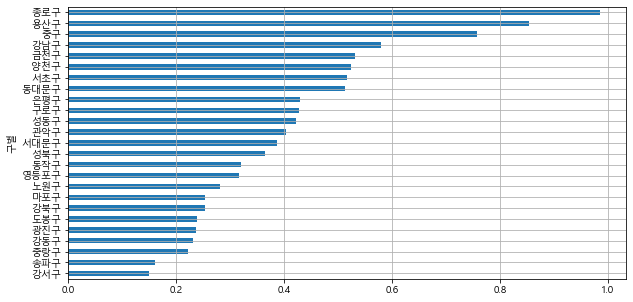

In [12]:
data_result["cctv비율"].sort_values().plot(kind="barh", figsize=(10, 5), grid=True)

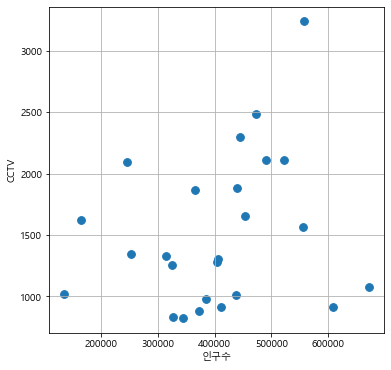

In [16]:
##### CCTV 개수와 인구수가 서로 관계가 있는지 산포도 확인

plt.figure(figsize=(6, 6))
plt.scatter(data_result["인구수"], data_result["소계"], s=60)
plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()

In [22]:
##### poly1d()

a = np.poly1d([1, 2])
print(a)

b = np.poly1d([1, 2, 3])
print(b)

X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([2, 3, 3, 5, 6, 7, 7, 10, 11])

c = np.polyfit(X, y, 1)
print(c)

d = np.poly1d(c)
print(d)

 
1 x + 2
   2
1 x + 2 x + 3
[1.11666667 0.41666667]
 
1.117 x + 0.4167


[1.10432363e-03 1.06864009e+03]
 
0.001104 x + 1069


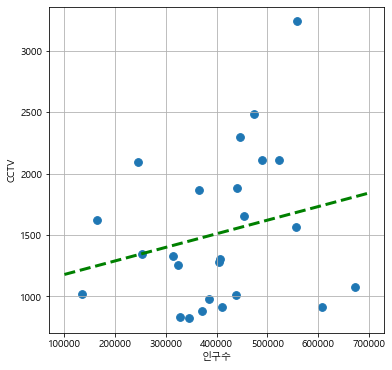

In [28]:
##### 회귀선 작성(y = ax + b)

fp1 = np.polyfit(data_result["인구수"], data_result["소계"], 1)
print(fp1)

f1 = np.poly1d(fp1)
print(f1)

fx = np.linspace(100000, 700000, 100)

plt.figure(figsize=(6, 6))
plt.scatter(data_result["인구수"], data_result["소계"], s=60)
plt.plot(fx, f1(fx), lw=3, color="g", ls="dashed")
#plt.plot(fx, fp1[0]*fx + fp1[1], lw=3, color="g", ls="dashed")
plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()

In [30]:
##### 각 데이터의 오차를 구해서 "오차" 파생변수로 추가

data_result["오차"] = np.abs(data_result["소계"] - f1(data_result["인구수"]))
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138,0.230475,542.582309
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606,0.253732,599.318223
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976,0.403797,463.580517


In [31]:
df_sort = data_result.sort_values(by="오차", ascending=False)
df_sort.head(10)

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
양천구,2482,34.671731,473087,469221,3866,56070,0.817186,11.851943,0.524639,890.918761
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
용산구,2096,53.216374,245411,229909,15502,37238,6.316750,15.173729,0.854077,756.346747
서초구,2297,63.371266,445164,440954,4210,54055,0.945719,12.142716,0.515990,736.754790
송파구,1081,104.347826,671994,665282,6712,77978,0.998818,11.603973,0.160865,729.738939
도봉구,825,246.638655,345041,342861,2180,54293,0.631809,15.735231,0.239102,624.677016
중랑구,916,79.960707,411552,406868,4684,59992,1.138131,14.577016,0.222572,607.126685
광진구,878,53.228621,371671,357149,14522,44470,3.907219,11.964883,0.236230,601.085154


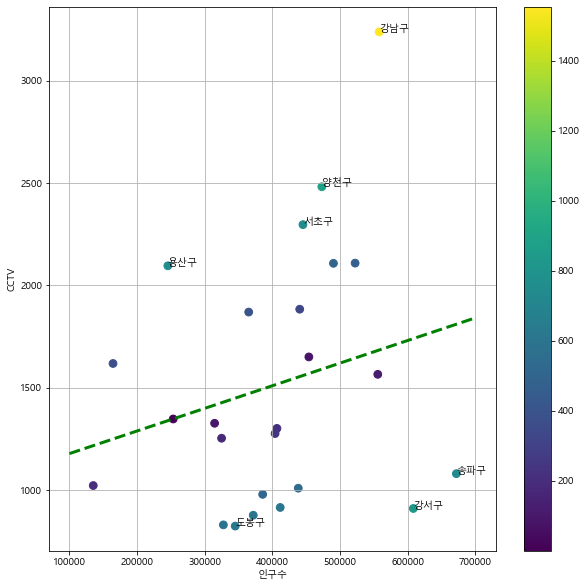

In [37]:
plt.figure(figsize=(10, 10))
plt.scatter(data_result["인구수"], data_result["소계"], s=60, c=data_result["오차"])
plt.plot(fx, f1(fx), lw=3, color="g", ls="dashed")

plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()
plt.colorbar()

for n in range(7):
    plt.text(df_sort["인구수"][n], df_sort["소계"][n], df_sort.index[n], fontsize=10)

In [38]:
##### 최종 결과물 파일로 저장

df_sort.to_csv("data/seoul/cctv_result.csv", sep=",", encoding="utf-8")